In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, an Oil ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the locally stationary mean and covariance within a cluster. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [2]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [3]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. 1st-order differencing of the 15 day rolling mean log price for each asset. This captures the auto-correlation structure of the time series which we then visualize. We want a higher and smoother auto-correlation than a 1st-order differencing of each time point alone hence the rolling metric. 

This clusters the data into regions where the mean is shifting in some significant way and preserves long memory. 

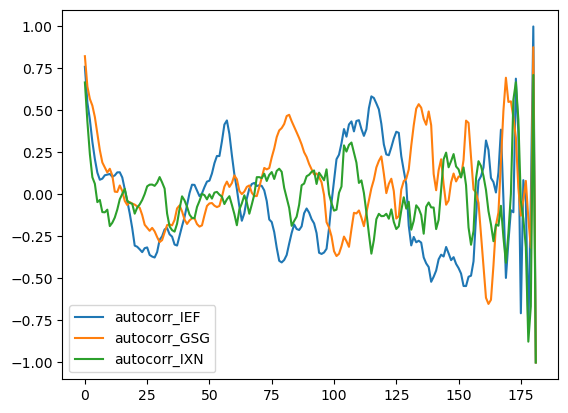

In [4]:
m6_subset = m6_assets.copy().apply(np.log).rolling(15).mean().diff().dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(1, len(autocorr_df)-1)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(1, len(autocorr_df)-1)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(1, len(autocorr_df)-1)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process and view the clustering results on the training data. 

In [5]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')

In [6]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

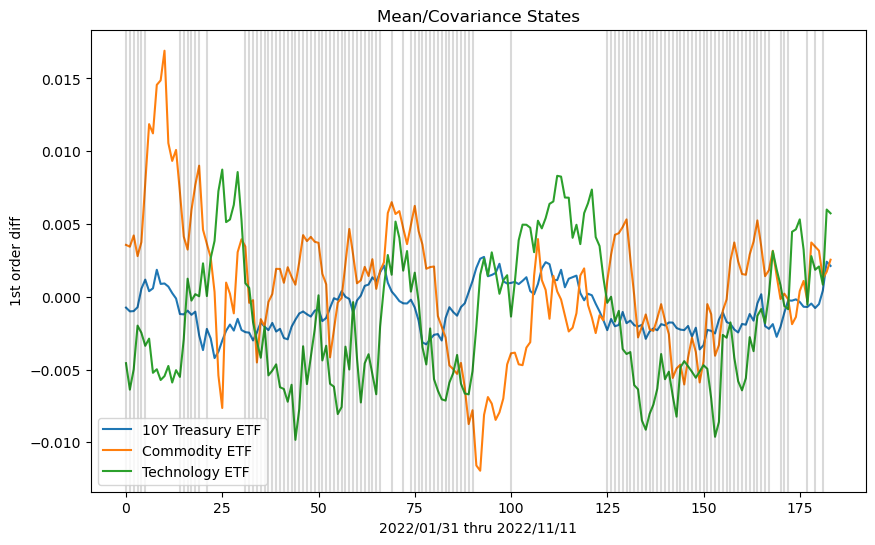

In [7]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF')
sns.lineplot(data=m6_subset['GSG'], ax=ax, label='Commodity ETF')
sns.lineplot(data=m6_subset['IXN'], ax=ax, label='Technology ETF')

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean/Covariance States')
ax.set_ylabel('1st order diff')
ax.set_xlabel(f'2022/01/31 thru 2022/11/11')
plt.show()

In [8]:
print(dpgmm_model.means_[:10])

[[-0.0008288   0.0006881  -0.00141647]
 [-0.00139686  0.00066546 -0.00384583]
 [-0.00082871  0.00068772 -0.00141647]
 [-0.00082865  0.00068744 -0.00141647]
 [-0.00082859  0.00068717 -0.00141647]
 [-0.00082852  0.0006869  -0.00141647]
 [-0.00082846  0.00068664 -0.00141647]
 [-0.00082841  0.00068639 -0.00141647]
 [-0.00021895  0.00038696  0.00436142]
 [-0.00082815  0.00068525 -0.00141646]]
